In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import pulp

import sys
sys.path.insert(0, '../..')
import leximin_assignment
import bottleneck_assignment
import assignment

import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

import warnings
from tqdm import tqdm

# When the first column is all-zero

In [28]:
N = 5

thresholds = np.sort(np.random.randint(0, 10 ** 6, N * 2 - 2))
thresholds

array([ 28198, 101560, 300533, 314428, 356142, 524165, 783093, 879912])

In [29]:
nonzero_cost_matrix = np.array([
    np.sort(np.random.randint(thresholds[2 * i], thresholds[2 * i + 1] + 1, N))
    for i in range(N - 1)
])

nonzero_cost_matrix

array([[ 31697,  81990,  84787,  90636,  95020],
       [301169, 303707, 306220, 307225, 311909],
       [437382, 440627, 447225, 476593, 511427],
       [786624, 833999, 850325, 869230, 874191]])

In [31]:
cost_matrix = np.concatenate((
    np.zeros((N,1)),
    nonzero_cost_matrix.T
), axis=1).astype(int)

cost_matrix

array([[     0,  31697, 301169, 437382, 786624],
       [     0,  81990, 303707, 440627, 833999],
       [     0,  84787, 306220, 447225, 850325],
       [     0,  90636, 307225, 476593, 869230],
       [     0,  95020, 311909, 511427, 874191]])

# Arbitrary cost matrix

In [32]:
def get_expected_efficient_assignments(thresholds):
    neg_ranges = np.array([
        thresholds[2 * i] - thresholds[2 * i + 1]
        for i in range(N)
    ])  # the negative ranges are more convenient to sort
    
    assignments = np.argsort(neg_ranges)
    expected_cost = (np.arange(1, N + 1).dot(- neg_ranges[assignments])) / (N + 1) \
                    + thresholds[::2].sum()
    
    return assignments, expected_cost

def get_expected_leximin_assignments(thresholds):
    ranges = np.array([
        thresholds[2 * i + 1] - thresholds[2 * i]
        for i in range(N)
    ])
    
    assignments = np.arange(N - 1, -1, -1)
    expected_cost = (np.arange(1, N + 1).dot(ranges[assignments])) / (N + 1) \
                    + thresholds[::2].sum()
    
    return assignments, expected_cost

In [48]:
N = 10
N_EXPERIMENTS = 5000
UPPER_LIM = 10 ** 6

thresholds = np.sort(np.random.randint(0, UPPER_LIM + 1, N * 2))
thresholds

array([ 59799,  66203, 120717, 189861, 252122, 301343, 321681, 497498,
       515194, 530422, 579729, 637747, 656841, 712149, 773591, 834269,
       862466, 925458, 967531, 972898])

In [49]:
efficient_costs = []
leximin_costs = []

for _ in tqdm(range(N_EXPERIMENTS)):
    cost_matrix = np.array([
        np.sort(np.random.randint(thresholds[2 * i], thresholds[2 * i + 1] + 1, N))
        for i in range(N)
    ]).T.astype(int)
    
    # Efficient assignment
    efficient_assigner = assignment.AssignmentHelperV2(
        cost_matrix, np.ones(N)
    )
    efficient_assignments = efficient_assigner.ip_solve()
    efficient_cost = efficient_assigner.get_cost(
        efficient_assignments, cost_matrix
    )
    
    efficient_costs.append(efficient_cost / UPPER_LIM)
    
    # Leximin assignment
    leximin_assigner = leximin_assignment.LeximinAssignmentHelperV3(
        cost_matrix, np.ones(N)
    )
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        leximin_assignments = leximin_assigner.solve()
    leximin_cost = leximin_assigner.get_cost(
        leximin_assignments, cost_matrix
    )
    
    leximin_costs.append(leximin_cost / UPPER_LIM)

100%|██████████| 5000/5000 [22:55<00:00,  3.63it/s]


Expected efficient cost: 5.286526272727272
Empirical efficient cost average: 5.260263392
Expected leximin cost: 5.403025363636363
Empirical leximin cost average: 5.402468283199999


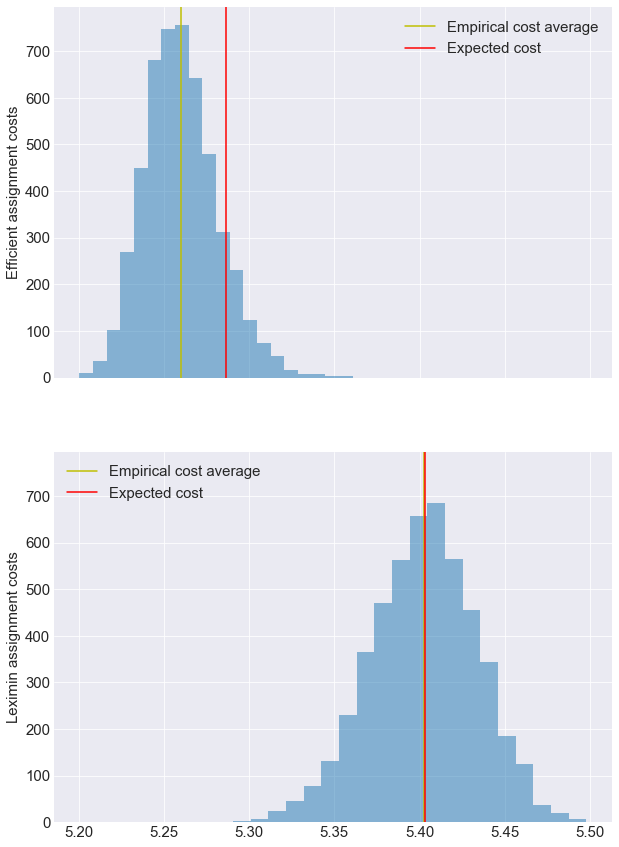

In [50]:
expected_efficient_assignments, expected_efficient_cost = get_expected_efficient_assignments(
    thresholds
)
expected_efficient_cost /= UPPER_LIM
print('Expected efficient cost:', expected_efficient_cost)
print('Empirical efficient cost average:', np.mean(efficient_costs))

expected_leximin_assignments, expected_leximin_cost = get_expected_leximin_assignments(
    thresholds
)
expected_leximin_cost /= UPPER_LIM
print('Expected leximin cost:', expected_leximin_cost)
print('Empirical leximin cost average:', np.mean(leximin_costs))

fig, ax = plt.subplots(2, 1, figsize=(10, 15), sharex=True, sharey=True)

ax[0].hist(efficient_costs, alpha=0.5, bins=20)
ax[0].axvline(np.mean(efficient_costs), c='y', label='Empirical cost average')
ax[0].axvline(expected_efficient_cost, c='r', label='Expected cost')

ax[0].legend()
ax[0].set_ylabel('Efficient assignment costs')

ax[1].hist(leximin_costs, alpha=0.5, bins=20)
ax[1].axvline(np.mean(leximin_costs), c='y', label='Empirical cost average')
ax[1].axvline(expected_leximin_cost, c='r', label='Expected cost')

ax[1].legend()
ax[1].set_ylabel('Leximin assignment costs')

plt.show()